# Modeling an orogenic system using FastScape: 7. Piedmont deposition

![Henry Mountains](HenryMountains.jpg "Henry Mountains")

We now wish to consider the effect of sedimentation at the foot of a mountain front (in a piedmont)

For this we will use the "sediment_model", which is an addition to the SPL model introduced by [Davy and Lague, 2009](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2008JF001146) and developed into an implicit and O(n) algorithm by [Yuan et al, 2019](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018JF004867). It states that the rate of change of topography is controlled by uplift, erosion and deposition and that deposition is proportional to the ratio of upstream sediment flux and water discharge. This gives the following equation (neglecting hillslope processes):

$$\frac{\partial h}{\partial t}=U-K_fA^mS^n+G\frac{Q_s}{A}=U-K_fA^mS^n+G\frac{U-\int_A\frac{\partial h}{\partial t}\ dA}{A}$$

where $G$ is a dimensionless factor estimated at around 1 or 2 [Guerit et al, 2019](https://pubs.geoscienceworld.org/gsa/geology/article/47/9/853/572094/Fluvial-landscape-evolution-controlled-by-the) but depends linearly on precipitation rate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('dark_background')

import xsimlab as xs
import xarray as xr
%load_ext xsimlab.ipython

from fastscape.models import sediment_model


The sediment model requires also several other parameters, such as separate values of Kf and G for bedrock and sediment and an exponent ($p$) that is used to control the divergence of water flow. If the exponent is very large, the flow is very focused; if the exponent is very small, the flow is very distributed. There are some theoeretical reasons to use $p=1$ but they are "weak"...

In [2]:
spl_model = sediment_model.drop_processes('diffusion')
spl_model.bedrock

<Bedrock 'bedrock' (xsimlab process)>
Variables:
    elevation          [inout] ('y', 'x') bedrock elevation
    depth                [out] ('y', 'x') bedrock depth below topog...
    bedrock_motion_up     [in] <--- vmotion.bedrock_upward
    surface_motion_up     [in] <--- vmotion.surface_upward
    surface_elevation     [in] <--- topography.elevation
Simulation stages:
    initialize
    run_step
    finalize_step

We compute $x$ and $y$ arrays to specify a space-variable uplift rate (only half fd the model is a mountain or is in uplift; the other half is not uplifting and represent the adjacent piedmont area)

In [3]:
x, y = np.meshgrid(np.linspace(0,300e3,301), np.linspace(0,100e3,101))

In [4]:
# %create_setup spl_model --default --verbose
import xsimlab as xs

ds_in = xs.create_setup(
    model=spl_model,
    clocks={'time': np.linspace(0,1e7,1001),
           'out': np.linspace(0,1e7,101)},
    master_clock = 'time',
    input_vars={
        # nb. of grid nodes in (y, x)
        'grid__shape': [101, 301],
        # total grid length in (y, x)
        'grid__length': [100e3, 300e3],
        # node status at borders
        'boundary__status': ['fixed_value', 'fixed_value', 'looped', 'looped'],
        # uplift rate
        'uplift__rate': 1e-3*np.where(x>200e3,1,0),
        # random seed
        'init_topography__seed': None,
        # MFD partioner slope exponent
        'flow__slope_exp': 1.0,
        # drainage area exponent
        'spl__area_exp': 0.4,
        # slope exponent
        'spl__slope_exp': 1,
        # bedrock channel incision coefficient
        'spl__k_coef_bedrock': 1e-5,
        # soil (sediment) channel incision coefficient
        'spl__k_coef_soil': 1e-5,
        # detached bedrock transport/deposition coefficient
        'spl__g_coef_bedrock': 1,
        # soil (sediment) transport/deposition coefficient
        'spl__g_coef_soil': 1,
    },
    output_vars={'topography__elevation': 'out',
                 'bedrock__elevation': 'out',
                'drainage__area': 'out'}
)


In [5]:
with xs.monitoring.ProgressBar():
    ds_out = ds_in.xsimlab.run(model=spl_model)

             0% | initialize 

In [6]:
from ipyfastscape import TopoViz3d

app = TopoViz3d(ds_out, canvas_height=600, time_dim="out")

app.components['background_color'].set_color('lightgray')
app.components['vertical_exaggeration'].set_factor(5)
app.components['timestepper'].go_to_time(ds_out.out[-1])

app.show()

Output(layout=Layout(height='640px'))

Looking at the $y$-averaged topography shows the formation of a fan and a alluvial plain connecting the mountain to the "ocean" or base level.

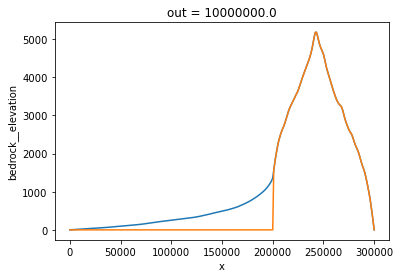

In [7]:
ds_out.topography__elevation.mean('y').isel(out=-1).plot()
ds_out.bedrock__elevation.mean('y').isel(out=-1).plot()

In fact there is an analytical solution to the steady-state of a sedimentary system deposited at the base of a "source" area according to the equation we use in FastScape

$$\frac{\partial h}{\partial t}=-K_f(\frac{A\nu}{w})^m|S|^n+\frac{Gw}{A\nu}q=-\frac{K_f}{w^m}(A\nu)^m|S|^n+\frac{Gw}{A\nu}(q_0-\int_0^x\frac{\partial h}{\partial t}\ dx)$$


![Setup](Sketch.jpg)

This analytical solution is:

$$h(x,t=\infty)=\int_x^L\frac{\partial h}{\partial x}\ dx=\bigl(\frac{q_0Gw^{m+1}}{K_f(A_0)^{m+1}}\bigr)^{1/n}\Bigl(L\ _2F_1(\frac{1}{p};\frac{m+1}{n};1+\frac{1}{p};-\frac{kL^p}{A_0})-x\ _2F_1(\frac{1}{p};\frac{m+1}{n};1+\frac{1}{p};-\frac{kx^p}{A_0})\Bigr)$$


It shows two different behaviors depending on whether the length of the system (distance between the source and the base level) is smaller or larger than a distance $L_0$ function of the upstream (source) catchment area:

$$L_0=(A_0/k)^{1/p}$$

![Analytical](Compare_analytical.jpg)

The exponent $m$ and $n$ control the distribution of sediment volume between the fan and the alluvial plain and, consequently, the relative slopes of the two systems.

![mn](Profile_mpn.jpg)

This analytical solution also explains nicely the observed relationship between upstream catchment area and fan area/fan slope:

![Fan Observations](Fan_observations.jpg)

Finally we can couple this system to an isostatic, flexural response using the "flexure" process.

This can be done by modifying the model (adding a process) and adjusting its inputs accordingly.

In [8]:
from fastscape.processes import Flexure

spl_model_flex = spl_model.update_processes({'flexure': Flexure})

in_vars = {'flexure__e_thickness': 20e3, 'flexure__asthen_density': 3200, 'flexure__lithos_density': 2800}
with xs.monitoring.ProgressBar(), spl_model_flex:
    ds_out_flex = ds_in.xsimlab.update_vars(input_vars=in_vars).xsimlab.run()

             0% | initialize 

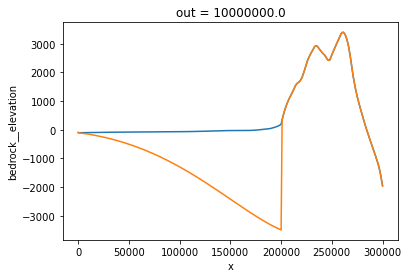

In [9]:
ds_out_flex.topography__elevation.mean('y').isel(out=-1).plot()
ds_out_flex.bedrock__elevation.mean('y').isel(out=-1).plot()